In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [73]:
df_train = pd.read_csv('data/training.csv')
df_test = pd.read_csv('data/test.csv')

In [74]:
df_train[:1]

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...


In [75]:
#we have columns with many missing values
#What we can do is fill the missing values with the mean of the column
#by dropping the Image column
lables_train = df_train.drop('Image', axis=1,)
labels_test = df_test.drop('Image', axis=1, )

#fillna
lables_train.fillna(lables_train.mean(), inplace=True)
labels_test.fillna(labels_test.mean(), inplace=True)

In [76]:
#get image from the dataframe

def get_image(Image:pd.Series):
    images = []
    for i in range(len(Image)):
        img = Image[i].split(' ')
        img = np.array(img, dtype=float).reshape(96,96)
        images.append(img)
    return np.array(images)

In [77]:
images_train = get_image(df_train['Image'])
images_test = get_image(df_test['Image'])
labels_train = lables_train.values
labels_test = labels_test.values

In [83]:
#plot figure function
def plot_figure(img:np.array, keypoints: np.array):
    plt.imshow(img, cmap='gray')
    plt.scatter(keypoints[::2], keypoints[1::2], s=10, marker='*', c='r')
    plt.show()

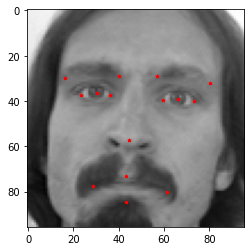

In [82]:
#plot a figure with the keypoints
plot_figure(images_train[0], labels_train[0])

In [88]:
#load necessary pytorch libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [93]:
X_train = torch.Tensor(images_train).view(-1, 1, 96, 96)
X_test = torch.Tensor(images_test).view(-1, 1, 96, 96)
y_train = torch.Tensor(labels_train)

In [94]:
#train and test dataset
train_set = torch.utils.data.TensorDataset(X_train, y_train)
test_set = torch.utils.data.TensorDataset(X_test)

In [95]:
#train and test dataloader
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)

In [99]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [106]:
#load pretrained ResNet34
import torchvision
model = torchvision.models.resnet34(pretrained=True)
#input channel is 1
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
#output layer gives 30 keypoints
model.fc = nn.Linear(512, 30)
model.to(device)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [107]:
#loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [109]:
#train the model
epochs = 100
for epoch in range(epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        #forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        #backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i+1) % 2 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch+1, epochs, i+1, len(train_loader), loss.item()))

Epoch [1/100], Step [2/111], Loss: 3.6462
Epoch [1/100], Step [4/111], Loss: 3.6277
Epoch [1/100], Step [6/111], Loss: 3.3084
Epoch [1/100], Step [8/111], Loss: 2.0880
Epoch [1/100], Step [10/111], Loss: 3.3071
Epoch [1/100], Step [12/111], Loss: 6.6097
Epoch [1/100], Step [14/111], Loss: 2.4291
Epoch [1/100], Step [16/111], Loss: 2.3974
Epoch [1/100], Step [18/111], Loss: 3.7344
Epoch [1/100], Step [20/111], Loss: 2.0682
Epoch [1/100], Step [22/111], Loss: 2.7171
Epoch [1/100], Step [24/111], Loss: 4.2108
Epoch [1/100], Step [26/111], Loss: 2.3788
Epoch [1/100], Step [28/111], Loss: 2.7452
Epoch [1/100], Step [30/111], Loss: 1.8373
Epoch [1/100], Step [32/111], Loss: 2.0971
Epoch [1/100], Step [34/111], Loss: 2.8345
Epoch [1/100], Step [36/111], Loss: 2.0078
Epoch [1/100], Step [38/111], Loss: 2.4825
Epoch [1/100], Step [40/111], Loss: 2.1837
Epoch [1/100], Step [42/111], Loss: 5.6119
Epoch [1/100], Step [44/111], Loss: 2.5889
Epoch [1/100], Step [46/111], Loss: 3.3755
Epoch [1/100], 